In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense


# Importar el data set
dataset = pd.read_csv('atp_matches_2023.csv')

In [85]:
X = dataset.iloc[:, [7, 15, -3, -1]].values
y = dataset.iloc[:, 7].values

In [86]:
# Reemplazar todos los valores NaN en 'X' por ceros
X = np.nan_to_num(X)

In [87]:
jugadores = pd.concat([dataset.iloc[:, 7], dataset.iloc[:, 15]])
num_jugadores = jugadores.nunique()

In [88]:
# Crear el codificador
encoder = OneHotEncoder(sparse_output=False)

# Ajustar el codificador con los datos de ambos jugadores
encoder.fit(X[:, [0, 1]].reshape(-1, 1))

# Transformar las columnas de los jugadores
player1_onehot = encoder.transform(X[:, 0].reshape(-1, 1))
player2_onehot = encoder.transform(X[:, 1].reshape(-1, 1))

# Concatenar las columnas one-hot con el resto de tus datos
X = np.concatenate([player1_onehot, player2_onehot, X[:, 2:]], axis=1)

In [89]:
# Crear una matriz de booleanos aleatorios del mismo tamaño que tus datos
swap = np.random.rand(len(X)) > 0.5

# Intercambiar las posiciones de los jugadores en 'X' donde 'swap' es True
X[swap, :num_jugadores], X[swap, num_jugadores:2*num_jugadores] = X[swap, num_jugadores:2*num_jugadores], X[swap, :num_jugadores].copy()

# Intercambiar las posiciones de los puntos en el ranking donde 'swap' es True
X[swap, -2], X[swap, -1] = X[swap, -1], X[swap, -2].copy()


In [90]:
# Crear el escalador
scaler = MinMaxScaler()

# Ajustar y transformar las dos últimas columnas de tus datos
X[:, -2:] = scaler.fit_transform(X[:, -2:]) 


In [91]:
# Transformar el vector objetivo 'y'
y = encoder.transform(y.reshape(-1, 1))


In [92]:
from sklearn.model_selection import train_test_split

# Luego, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [93]:
# Vamos a inferir la media poblacional a partir de una muestra aleatoria simple con n = 300
muestras = [0 for _ in range(300)]
for i in range(300):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X_train.astype('float64')
    y_train = y_train.astype('float64')
    # Definimos el modelo
    model = Sequential()

    # Añadir la capa de entrada y la primera capa oculta
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    # Añadir la segunda capa oculta
    # model.add(Dense(units=32, activation='tanh'))

    # Añadir la capa de salida
    model.add(Dense(units=y.shape[1], activation='softmax'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=15, batch_size=32)

    X_test = X_test.astype('float64')
    y_test = y_test.astype('float64')

    # Hacemos la predicción
    prediccion_test = model.predict(X_test)

    # Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
    indices_1 = np.where(X_test[:, :440] == 1)[1]
    indices_2 = np.where(X_test[:, 440:880] == 1)[1]

    # Obtenemos las predicciones para los índices obtenidos
    predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
    predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

    # Encontramos el índice del máximo para cada fila
    max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

    # Convertimos max_indices en un array 2D
    max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

    # Usamos el codificador para transformar los índices a sus etiquetas originales
    etiquetas_predichas = encoder.inverse_transform(max_indices_2D)
    etiqueta_y_test = encoder.inverse_transform(y_test)
    # Veamos cuántos partidos ha acertado para el test
    aciertos = 0
    for j in range(len(etiquetas_predichas)):
        if etiquetas_predichas[j] == etiqueta_y_test[j]:
            aciertos += 1
    precision = aciertos / len(etiquetas_predichas)*100
    muestras[i] = precision
    print(i)

Epoch 1/15


75/75 [==============================] - 1s 4ms/step - loss: 5.8584 - accuracy: 0.0896
Epoch 2/15
75/75 [==============================] - 0s 4ms/step - loss: 4.8116 - accuracy: 0.1118
Epoch 3/15
75/75 [==============================] - 0s 3ms/step - loss: 4.2712 - accuracy: 0.2345
Epoch 4/15
75/75 [==============================] - 0s 3ms/step - loss: 3.7989 - accuracy: 0.4075
Epoch 5/15
75/75 [==============================] - 0s 3ms/step - loss: 3.2791 - accuracy: 0.5431
Epoch 6/15
75/75 [==============================] - 0s 3ms/step - loss: 2.7556 - accuracy: 0.6177
Epoch 7/15
75/75 [==============================] - 0s 3ms/step - loss: 2.2824 - accuracy: 0.6696
Epoch 8/15
75/75 [==============================] - 0s 3ms/step - loss: 1.8827 - accuracy: 0.6968
Epoch 9/15
75/75 [==============================] - 0s 3ms/step - loss: 1.5563 - accuracy: 0.7274
Epoch 10/15
75/75 [==============================] - 0s 3ms/step - loss: 1.2953 - accuracy: 0.7621
Epoch 11/15
75/75 [===========

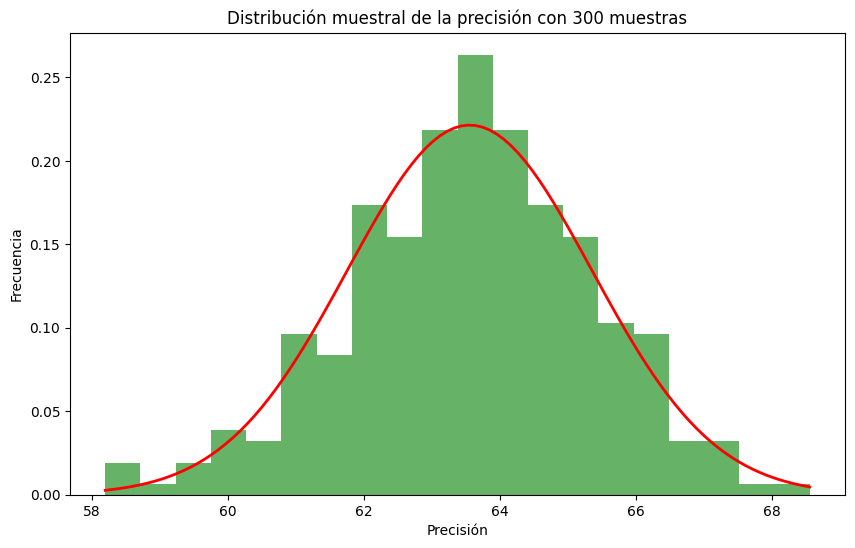

63.555741360089186 1.8014154487078866 63.7123745819398


In [94]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calcular la media y la desviación estándar de las muestras
mu, std = np.mean(muestras), np.std(muestras)

# Generar la distribución gaussiana
gaussian = norm(loc=mu, scale=std)

# Crear un array de valores x para la gráfica
x = np.linspace(min(muestras), max(muestras), 100)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.hist(muestras, bins=20, density=True, alpha=0.6, color='g')
plt.plot(x, gaussian.pdf(x), 'r', linewidth=2)
plt.title('Distribución de las predicciones y la gaussiana')
plt.xlabel('Precisión')
plt.ylabel('Frecuencia')
plt.title('Distribución muestral de la precisión con 300 muestras')
plt.show()
print(mu, std, np.median(muestras))

In [95]:
max(muestras)

68.56187290969899

In [96]:
print(mu, std, np.median(muestras))

63.555741360089186 1.8014154487078866 63.7123745819398


In [97]:
# Definimos el modelo
model = Sequential()

# Añadir la capa de entrada y la primera capa oculta
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))

# Añadir la segunda capa oculta
# model.add(Dense(units=64, activation='tanh'))

# Añadir la capa de salida
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
75/75 [==============================] - 1s 3ms/step - loss: 5.8431 - accuracy: 0.1181
Epoch 2/15
75/75 [==============================] - 0s 3ms/step - loss: 4.7815 - accuracy: 0.1139
Epoch 3/15
75/75 [==============================] - 0s 3ms/step - loss: 4.2489 - accuracy: 0.2182
Epoch 4/15
75/75 [==============================] - 0s 3ms/step - loss: 3.7878 - accuracy: 0.4020
Epoch 5/15
75/75 [==============================] - 0s 3ms/step - loss: 3.2768 - accuracy: 0.5444
Epoch 6/15
75/75 [==============================] - 0s 3ms/step - loss: 2.7600 - accuracy: 0.6185
Epoch 7/15
75/75 [==============================] - 0s 3ms/step - loss: 2.2918 - accuracy: 0.6625
Epoch 8/15
75/75 [==============================] - 0s 3ms/step - loss: 1.8890 - accuracy: 0.6922
Epoch 9/15
75/75 [==============================] - 0s 3ms/step - loss: 1.5554 - accuracy: 0.7198
Epoch 10/15
75/75 [==============================] - 0s 3ms/step - loss: 1.2920 - accuracy: 0.7504
Epoch 11/15
75/75 [

In [101]:
# Hacemos la predicción
prediccion_test = model.predict(X_test)

# Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
indices_1 = np.where(X_test[:, :440] == 1)[1]
indices_2 = np.where(X_test[:, 440:880] == 1)[1]

# Obtenemos las predicciones para los índices obtenidos
predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

# Encontramos el índice del máximo para cada fila
max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

# Convertimos max_indices en un array 2D
max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

# Usamos el codificador para transformar los índices a sus etiquetas originales
etiquetas_predichas = encoder.inverse_transform(max_indices_2D)
print(etiquetas_predichas)

19/19 [==============================] - 0s 1ms/step
[[106045.]
 [105173.]
 [111797.]
 [126845.]
 [121411.]
 [104925.]
 [202104.]
 [104755.]
 [126207.]
 [126127.]
 [126094.]
 [133835.]
 [106296.]
 [208103.]
 [144895.]
 [206173.]
 [122330.]
 [202103.]
 [200005.]
 [134868.]
 [206173.]
 [104755.]
 [126774.]
 [100644.]
 [132283.]
 [106234.]
 [208029.]
 [106432.]
 [200514.]
 [104792.]
 [202103.]
 [200647.]
 [210097.]
 [144869.]
 [104792.]
 [106432.]
 [126774.]
 [106234.]
 [126128.]
 [209950.]
 [126409.]
 [126203.]
 [200059.]
 [111575.]
 [100644.]
 [200000.]
 [126094.]
 [208029.]
 [207669.]
 [209098.]
 [106218.]
 [126774.]
 [106421.]
 [132283.]
 [200615.]
 [207881.]
 [209098.]
 [200615.]
 [134770.]
 [126128.]
 [206173.]
 [200325.]
 [111815.]
 [200303.]
 [125802.]
 [111575.]
 [105077.]
 [208029.]
 [105583.]
 [111797.]
 [126205.]
 [209992.]
 [208029.]
 [106423.]
 [126952.]
 [106421.]
 [208286.]
 [106186.]
 [111456.]
 [208286.]
 [104527.]
 [207686.]
 [132283.]
 [100644.]
 [105077.]
 [200221.]
 

In [102]:
# Usamos el codificador para transformar las etiquetas codificadas a sus etiquetas originales
etiqueta_y_test = encoder.inverse_transform(y_test)

print(etiqueta_y_test)

[[106045.]
 [105173.]
 [105870.]
 [208260.]
 [121411.]
 [104925.]
 [202104.]
 [104755.]
 [126207.]
 [104898.]
 [126094.]
 [133835.]
 [207518.]
 [202104.]
 [208230.]
 [206173.]
 [124116.]
 [202103.]
 [200005.]
 [134868.]
 [206173.]
 [104755.]
 [126774.]
 [100644.]
 [202103.]
 [132283.]
 [208029.]
 [106432.]
 [200267.]
 [104792.]
 [202103.]
 [131951.]
 [210097.]
 [144869.]
 [111442.]
 [105550.]
 [126774.]
 [127339.]
 [106045.]
 [209950.]
 [106220.]
 [126203.]
 [105916.]
 [111575.]
 [100644.]
 [200000.]
 [126094.]
 [200221.]
 [207669.]
 [106331.]
 [208103.]
 [126774.]
 [106421.]
 [132283.]
 [200615.]
 [206600.]
 [106331.]
 [200615.]
 [134770.]
 [126128.]
 [206173.]
 [208103.]
 [200282.]
 [200303.]
 [125802.]
 [111575.]
 [144719.]
 [105777.]
 [105583.]
 [111797.]
 [126205.]
 [105453.]
 [208029.]
 [207733.]
 [126952.]
 [106421.]
 [122298.]
 [106329.]
 [111456.]
 [133430.]
 [104527.]
 [207686.]
 [132283.]
 [100644.]
 [105077.]
 [200221.]
 [104925.]
 [144869.]
 [122669.]
 [200303.]
 [104527.]

In [103]:
# Veamos cuántos partidos ha acertado para el test
aciertos = sum(etiquetas_predichas == etiqueta_y_test)
precision = aciertos / len(etiquetas_predichas)*100
print(precision[0])

62.04013377926422
